90


Transforming over 1000 elements to C_CONTIGUOUS.


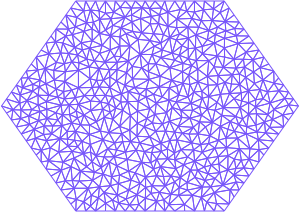

In [181]:
import matplotlib.pyplot as plt
import skfem
import random
import scipy
from scipy.sparse import csc_matrix
from scipy.spatial import Delaunay
import numpy as np
from skfem import MeshTri
from scipy.spatial import distance
from scipy.sparse.linalg import splu  # for sparse matrices, 
# returns something like invA with LU decomp which can be applied with solve to solve Ax = b for x
from skfem.models.poisson import laplace, mass
from skfem.visuals.matplotlib import plot
'''from matplotlib.patches import Polygon
from matplotlib.path import Path
from skfem.models.poisson import laplace, mass
from skfem.visuals.matplotlib import plot'''
from shapely.geometry import Polygon,Point
%matplotlib inline

vertices = np.array([[1,0.5],[0.7500,0.8546],[0.25,0.8546],[0,0.5],[0.25,0.1454],[0.75,0.1454]])

def generate_boundary_points(vertices,num_points_per_side):
    points = []
    for i in range(6):
        start_vertex = vertices[i]
        end_vertex = vertices[(i+1)%6]
        for j in range(num_points_per_side):
            t = j / num_points_per_side
            point = (1 - t) * start_vertex + t * end_vertex
            points.append(point)
    return np.array(points)
def generate_interior_points(vertices,num_points, min_distance,boundary_points):
    hexagon = Polygon(vertices)
    x_min, y_min, x_max, y_max = hexagon.bounds
    x_points, y_points = [], []
    def is_inside_hexagon(x,y):
        return hexagon.contains(Point(x,y))
    points = boundary_points.tolist()
    '''points = []'''
    while len(points) < num_points:
        x_rand = np.random.uniform(x_min, x_max)
        y_rand = np.random.uniform(y_min, y_max)
        #point = []
        pt = np.array([x_rand,y_rand])
        if is_inside_hexagon(x_rand, y_rand):
            '''if all(np.linalg.norm(np.array([x_rand, y_rand]) - np.array([xp, yp])) >= min_distance for xp, yp in zip(x_points, y_points)):'''"How do we represent probability in precise mathematics.pdf"
            if all(distance.euclidean(pt, p) >= min_distance for p in points):
                '''point.append(x_rand)
                point.append(y_rand)'''
                points.append(pt)
                #x_points.append(x_rand)
                #y_points.append(y_rand)
                
    return np.array(points)


minimum_distance = 0.0225
num_points_per_side = 15
boundary_points = generate_boundary_points(vertices,num_points_per_side)
print(len(boundary_points))
num_points = 600
interior_points = generate_interior_points(vertices,num_points,minimum_distance,boundary_points)

all_points = np.vstack((boundary_points,interior_points))
tri = Delaunay(all_points)
mesh = MeshTri(all_points.T,tri.simplices.T)

'''plt.triplot(all_points[:, 0], all_points[:, 1], tri.simplices, color='blue')
plt.scatter(all_points[:, 0], all_points[:, 1], color='red', s=1.75)
plt.gca().set_aspect(1.0)
fig = plt.gcf()
fig.set_size_inches(10, 10)
plt.show()'''
mesh

C:\Users\yuche\AppData\Local\Temp\ipykernel_11120\2824503610.py:33: SparseEfficiencyWarning: splu converted its input to CSC format
  backsolve_1 = splu(A_1_csc.T).solve
C:\Users\yuche\AppData\Local\Temp\ipykernel_11120\2824503610.py:34: SparseEfficiencyWarning: splu converted its input to CSC format
  backsolve_2 = splu(A_2_csc.T).solve


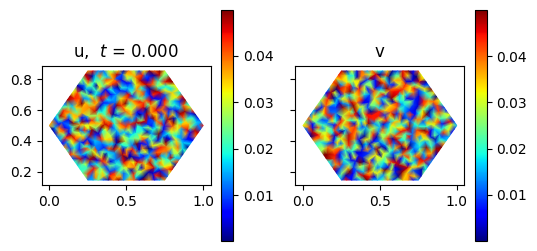

In [182]:
element = skfem.ElementTriP1()  # or ElementTriP2?  a triangular element
basis = skfem.Basis(mesh, element)

D_u  = 1.e-3  #diffusion coefficients 
D_v = D_u*11
dt = .004    # timestep 

L_1 = D_u * skfem.asm(laplace, basis)   # Laplacian for u field 
L_2 = D_v * skfem.asm(laplace, basis)   # for v field 
M = skfem.asm(mass, basis)  # mass matrix (sizes of triangles) 

#L0, M0 = penalize(L, M, D=basis.get_dofs())  # sets boundary to zero Dirichlet boundary 
#L0=L;  #M0=M;
# ACQ otherwise gives Neumann boundary condition!!!!!! 

theta = 0.5                     # Crank–Nicolson algorithm for a diffusion PDE
A_1 = M + theta * L_1 * dt
B_1 = M - (1 - theta) * L_1 * dt
A_2 = M + theta * L_2 * dt
B_2 = M - (1 - theta) * L_2 * dt

# Convert to CSC format
A_1_csc = csc_matrix(A_1)
A_2_csc = csc_matrix(A_2)

# Regularize matrices
epsilon = 1e-10
A_1_csc += epsilon * np.eye(A_1_csc.shape[0])
A_2_csc += epsilon * np.eye(A_2_csc.shape[0])

# Perform factorization
try:
    backsolve_1 = splu(A_1_csc.T).solve
    backsolve_2 = splu(A_2_csc.T).solve
except RuntimeError as e:
    print("RuntimeError:", e)

#backsolve_1 = splu(A_1.T).solve  # .T as splu prefers CSC which is a sparse matrix format (compressed sparse column)
#backsolve_2 = splu(A_2.T).solve

nnodes = len(basis.doflocs[0])
u_init = np.random.random(nnodes)*0.05
v_init = np.random.random(nnodes)*0.05

def Reaction(u,v,alpha,beta,rdtype):
    if (rdtype == 'FN'):  # FitzHugh Nagumo model
        Ru,Rv=R_FN(u,v,alpha,beta)
        return Ru,Rv
    if (rdtype == 'Br'):  # Brusellator model
        Ru,Rv= R_Br(u,v,alpha,beta)
        return Ru,Rv
    if (rdtype == 'GS'):  # Gray-Scott model
        Ru,Rv = R_GS(u,v,alpha,beta)
        return Ru,Rv
    if (rdtype == 'Heat'):  # Heat equation 
        n = len(u)
        Ru = np.zeros(n); Rv = np.zeros(n)
        return Ru,Rv
    print('invalid reaction type')

#The FitzHugh-Nagumo Reaction Diffusion Model
# example: Du, Dv, alpha, beta = 1, 10, 0.1, 1, dt=0.01, dx = 1
def R_FN(u,v,alpha,beta): 
    Ru =  u - u**3 - v + alpha 
    Rv = (u - v)*beta
    return Ru,Rv
    
# Brusselator Reaction Diffusion model
# example: Du, Dv, alpha, beta = 2, 22, 5, 9 # dt=0.005, dx=1
# u = alpha, v = beta/alpha is a fixed point of R
def R_Br(u,v,alpha,beta): 
    Ru = alpha - (beta+1)*u + (u**2)*v    
    Rv = beta*u - (u**2)*v
    return Ru,Rv

# The Gray-Scott Reaction Diffusion model
# alpha is feed rate for u and kills v, beta is kill or drain rate for v
# example: Du = 0.2, Dv = Du/2, alpha = 0.037 and beta = 0.06 , dx=1
def R_GS(u,v,alpha,beta): 
    Ru =  -u*(v**2) + alpha*(1-u) 
    Rv =  u*(v**2) -(alpha+ beta)*v
    return Ru,Rv

# display u,v fields 
# calls skfem's plot routine 
def disp(mesh,u,v,basis,t):
    fig,axarr = plt.subplots(1,2,figsize=(6,3),sharex=True,sharey=True)
    ax0 = axarr[0]; ax1 = axarr[1]
    ax0.set_aspect('equal'); ax1.set_aspect('equal')
    ax_j0 = plot(mesh, u[basis.nodal_dofs.flatten()], shading='gouraud', ax = ax0)
    ax_j1 = plot(mesh, v[basis.nodal_dofs.flatten()], shading='gouraud', ax = ax1)
    fig = ax0.get_figure()
    field0 = ax0.get_children()[0]  # vertex-based temperature-colour
    field1 = ax1.get_children()[0]  # vertex-based temperature-colour
    fig.colorbar(field0)
    fig.colorbar(field1)
    title = ax0.set_title(f'u,  $t$ = {t:.3f}')
    title = ax1.set_title(f'v')

# show initial conditions 
t=0
disp(mesh,u_init,v_init,basis,t)

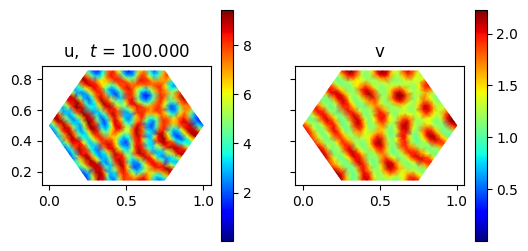

In [183]:
def one_step(t,u,v):
    t += dt
    Ru,Rv = Reaction(u,v,alpha,beta,rdtype)
    u = backsolve_1(B_1 @ u)    
    v = backsolve_2(B_2 @ v)  
    u += Ru*dt
    v += Rv*dt
    return t,u,v

u = u_init; v = v_init; t=0; 
rdtype = 'Br'
alpha = 6.; beta = 9.

for i in range(25000):
    t, u, v = one_step(t,u,v)  
disp(mesh,u,v,basis,t)

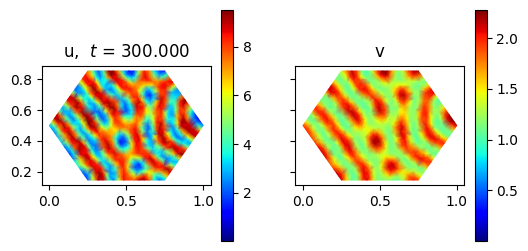

In [184]:

for i in range(50000):
    t, u, v = one_step(t,u,v)  
disp(mesh,u,v,basis,t)